#                        REAL OR FAKE JOB POSTING

# Making Necessary Imports

In [214]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Reading Dataset

In [215]:
df = pd.read_csv("fake_job_postings.csv")

# Data Quality

In [216]:
df.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


In [217]:
df.shape

(17880, 18)

In [218]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [219]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


# Data Type

In [220]:
t = [len(df.select_dtypes(include=['object']).columns.tolist()),len(df.select_dtypes(exclude=['object']).columns.tolist())]
label = ['Discreete','Numeric']

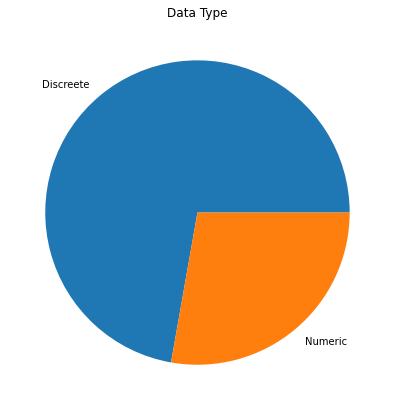

In [221]:
fig = plt.figure(figsize =(10, 7))
plt.title('Data Type')
plt.pie(t, labels = label)
plt.show()

***Most of our Data is Discreete. There are few numeric columns and even they are not continuous. There is only 1 continuous variable i.e. Salary_range***

# EDA

In [222]:
df.duplicated().sum()

0

***There are no duplicate rows in the dataset***

In [223]:
print('Total Nan values out of ',df.shape[0]*df.shape[1],'are',df.isnull().sum().sum())

Total Nan values out of  321840 are 70103


<AxesSubplot:>

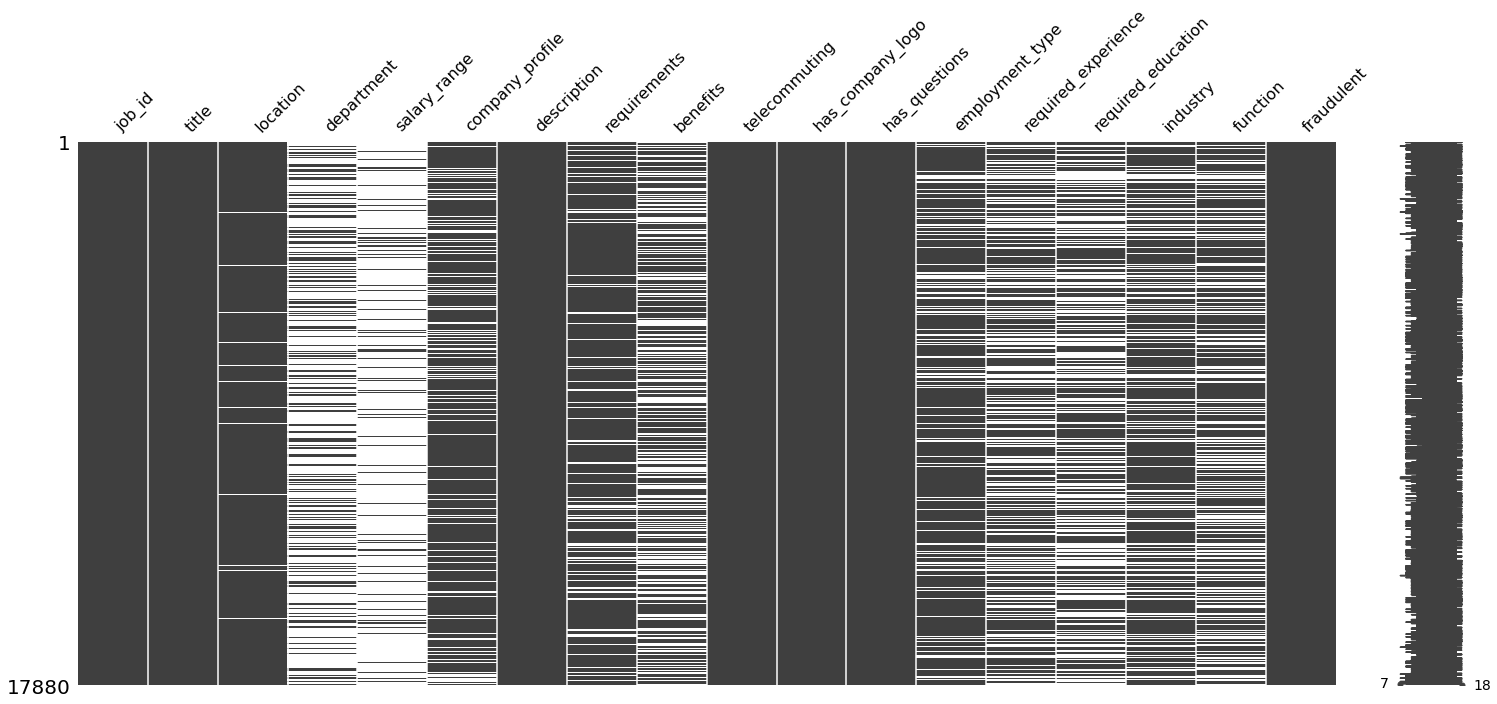

In [224]:
missingno.matrix(df)

***Here white means more missing values***

In [225]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

***Alot of missing values under the column department and salary range so we have to drop them. Also job_id is a useless column so we can also drop this one.***

In [226]:
df.drop(columns = ['department','salary_range','job_id'],inplace = True)

In [227]:
df.head(3)

,title,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


***Still we have some missing values in remaining features. We'll drop the row containing Nan values*** 

In [228]:
df = df.dropna()

In [229]:
df.shape

(4441, 15)

***After cleaning the dataframe, we're only left with 4441 rows and 14 features***

In [230]:
label_count = [df['fraudulent'].value_counts()[0],df['fraudulent'].value_counts()[1]]
label = ['real','fake']

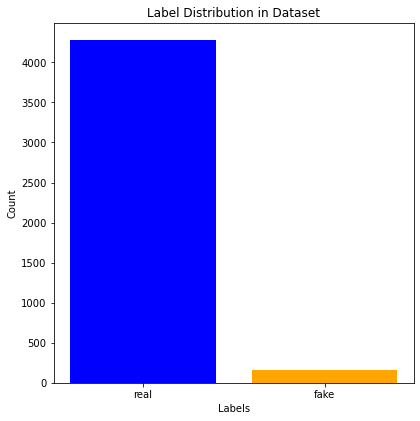

In [231]:
fig = plt.figure(figsize =(5, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Count')
ax.set_xlabel('Labels')
ax.set_title('Label Distribution in Dataset')
ax.bar(label,label_count,color = ['blue','orange'])
plt.show()

In [232]:
print('Real:', label_count[0])
print('Fake:', label_count[1])

Real: 4280
Fake: 161


***After cleaning the dataset, we're only left with only few fake jobs. So, there is a high data imbalance.***

***We can add extract 3 columns from location column, i.e. city, state and country***

In [233]:
df = df.drop(df[df['location'].str.count(',') != 2].index)
df['country'], df['state'], df['city'] = df['location'].str.split(',', 2).str
df = df.drop(['location'], axis=1)
df.head(3)

<ipython-input-233-33f55ff6babf>:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['country'], df['state'], df['city'] = df['location'].str.split(',', 2).str


,title,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,state,city
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC,Washington
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL,Fort Worth
6,Head of Content (m/f),"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0,DE,BE,Berlin


In [234]:
jobs_count = df['country'].value_counts()[0:10]
country = df['country'].value_counts()[0:10].index

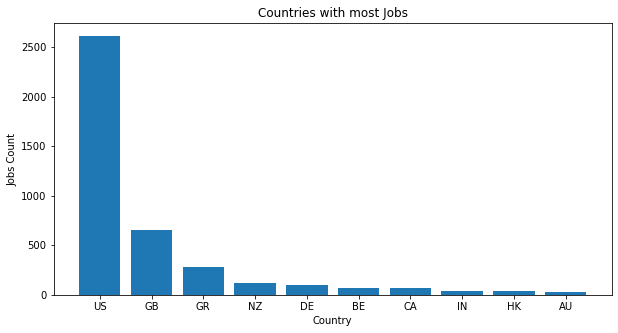

In [235]:
fig = plt.figure(figsize =(10, 5))
plt.ylabel('Jobs Count')
plt.xlabel('Country')
plt.title('Countries with most Jobs')
plt.bar(country,jobs_count)
plt.show()

***US has most number of jobs offered***

In [236]:
e_type = df['employment_type'].value_counts().index
e_count = df['employment_type'].value_counts()
e = (0,0.1,0.15,0.2,0.25)

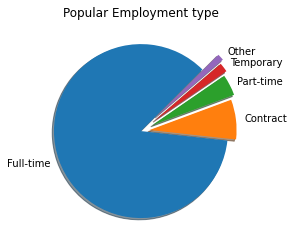

In [237]:
plt.pie(e_count,labels=e_type,explode=e,shadow=True,startangle=45)
plt.title('Popular Employment type')
plt.show()

***Full time jobs are most required in the job market***

In [238]:
i_names = df['industry'].value_counts()[0:10].index
i_count = df['industry'].value_counts()[0:10]

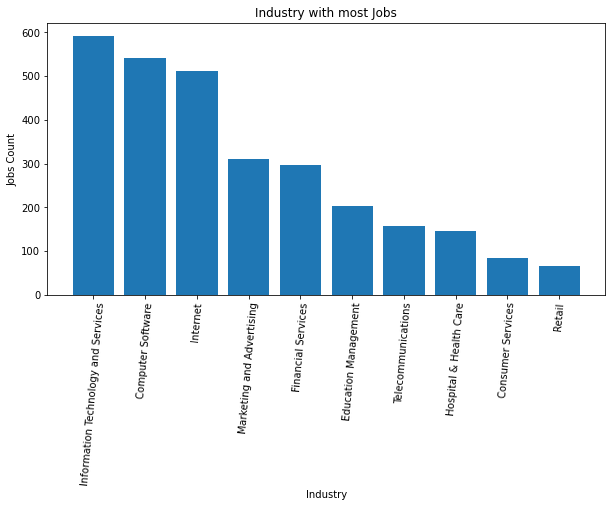

In [239]:
fig = plt.figure(figsize =(10, 5))
plt.ylabel('Jobs Count')
plt.xlabel('Industry')
plt.title('Industry with most Jobs')
plt.bar(i_names,i_count)
plt.xticks(rotation=85)
plt.show()

***CS and IT fields are most popular in job market***

In [240]:
experience_req = (df.required_experience.value_counts()[0]/df.required_experience.value_counts().sum())*100

In [241]:
print(experience_req,'pecent of the jobs are looking for',df.required_experience.value_counts().index[0],'experience')

33.29542870138731 pecent of the jobs are looking for Mid-Senior level experience


***Those were the general questions. Now lets go for the classification of jobs as real or fake***

***First I'll analyze the texual features. Lets combine company profile, description, requirments and benefits and try to anylyze the new column***

In [242]:
df['text'] = df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits']

***Lets check the Word Cloud of both classes***

In [243]:
fraudjobs_text = df[df.fraudulent==1].text
realjobs_text = df[df.fraudulent==0].text
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

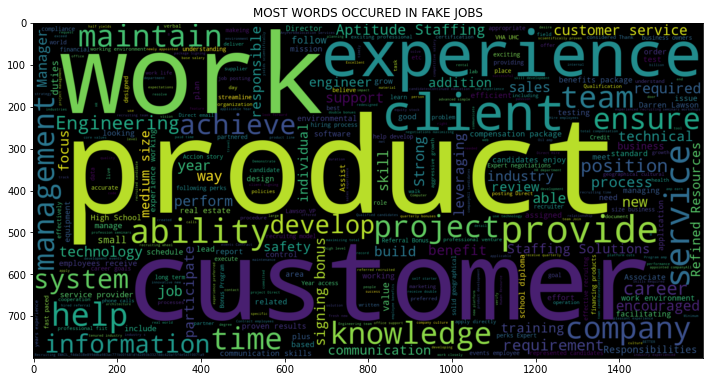

In [244]:
plt.figure(figsize = (12,8))
cloud = WordCloud(min_font_size = 5,  max_words = 4000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.title("MOST WORDS OCCURED IN FAKE JOBS")
plt.imshow(cloud,interpolation = 'bilinear')

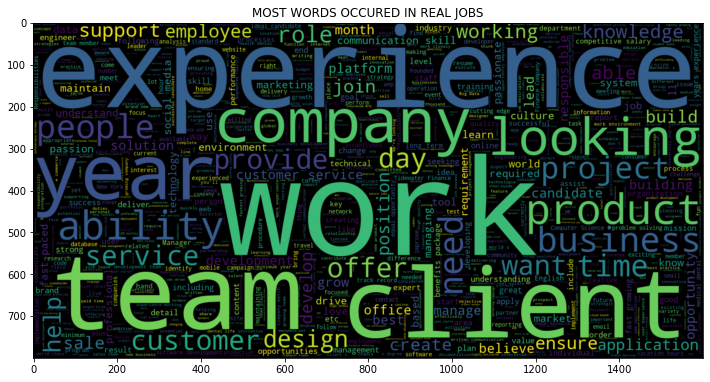

In [245]:
plt.figure(figsize = (12,8))
cloud = WordCloud(min_font_size = 5,  max_words = 4000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(realjobs_text)))
plt.title("MOST WORDS OCCURED IN REAL JOBS")
plt.imshow(cloud,interpolation = 'bilinear')

***Lets create some numeric features ourselfs and check weather they are impacting the output***

In [246]:
company_profile = df['company_profile'].tolist()
description = df['description'].tolist()

In [247]:
profile_count = []
description_count = []
for i in range(len(description)):
    profile_count.append(len(re.findall(r'\w+', company_profile[i])))
    description_count.append(len(re.findall(r'\w+', description[i])))

In [248]:
df['profile_count'] = profile_count
df['description_count'] = description_count

In [249]:
df.head(3)

,title,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,state,city,text,profile_count,description_count
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC,Washington,Our passion for improving quality of life thro...,90,355
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL,Fort Worth,SpotSource Solutions LLC is a Global Human Cap...,213,179
6,Head of Content (m/f),"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0,DE,BE,Berlin,"Founded in 2009, the Fonpit AG rose with its i...",141,60


In [250]:
profile_mean = [df[df.fraudulent==1].profile_count.mean(),df[df.fraudulent==0].profile_count.mean()]
profile_label = ['Fake','Real']
description_mean = [df[df.fraudulent==1].description_count.mean(),df[df.fraudulent==0].description_count.mean()]
description_label = ['Fake','Real']

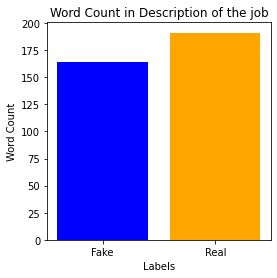

In [251]:
fig = plt.figure(figsize =(4, 4))
plt.ylabel('Word Count')
plt.xlabel('Labels')
plt.title('Word Count in Description of the job')
plt.bar(description_label,description_mean,color = ['blue','orange'])
plt.show()

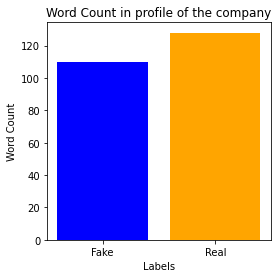

In [252]:
fig = plt.figure(figsize =(4, 4))
plt.ylabel('Word Count')
plt.xlabel('Labels')
plt.title('Word Count in profile of the company')
plt.bar(profile_label,profile_mean,color = ['blue','orange'])
plt.show()

***Real companies have slightly higher word count in their profile and job description***

***Finally Lets perform some analysis on categorical variables as well***

In [253]:
remote_fake = (len(df[(df.fraudulent==1) & (df.telecommuting == 1)])/df['fraudulent'].value_counts()[1])*100
remote_real = (len(df[(df.fraudulent==0) & (df.telecommuting == 1)])/df['fraudulent'].value_counts()[0])*100
telecommuting_label = ['fake','real']
telecommuting_percentage = [remote_fake,remote_real]

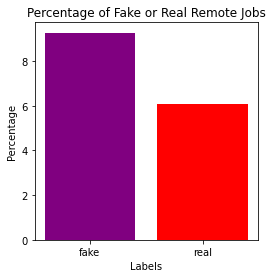

In [254]:
fig = plt.figure(figsize =(4, 4))
plt.ylabel('Percentage')
plt.xlabel('Labels')
plt.title('Percentage of Fake or Real Remote Jobs')
plt.bar(telecommuting_label,telecommuting_percentage,color = ['purple','red'])
plt.show()

***Chances of remote jobs to be fake is much higher than real jobs***

In [255]:
logo_fake = (len(df[(df.fraudulent==1) & (df.has_company_logo == 0)])/df['fraudulent'].value_counts()[1])*100
logo_real = (len(df[(df.fraudulent==0) & (df.has_company_logo == 0)])/df['fraudulent'].value_counts()[0])*100
logo_label = ['fake','real']
logo_percentage = [logo_fake,logo_real]

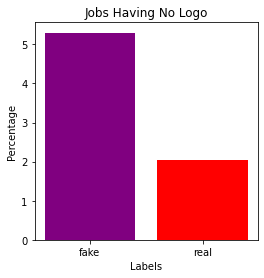

In [256]:
fig = plt.figure(figsize =(4, 4))
plt.ylabel('Percentage')
plt.xlabel('Labels')
plt.title('Jobs Having No Logo')
plt.bar(logo_label,logo_percentage,color = ['purple','red'])
plt.show()

***Fake companies have more no comapny logos than real ones***

***After checking the quality of data, we first decided to clean the data as there were alot of missing values. The we analyzed texual data by looking at the world cloud. Then we added some numerical features and analyzed their impact on the output. In the end we did EDA on categorical features in our dataset. In the next phase we'll apply different predictive models to estimate the output by giving more weights to important features which we've found during EDA. We'll comapre different models and will try to choose the best model.***

***CREDITS:***
<br>***TALHA TAHIR***<br>
***TALHA ZUBAIR***<br>
***MAHAD***<br>
***ADEEN***<br>

***Thank You***